In [6]:
import numpy as np
import pandas as pd
import os.path
import shutil
import datetime
from dateutil.rrule import rrule, YEARLY
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [7]:
#generated_path = 'E:\\dtuklaptop\\e\\Users\\Mat\\python\\data\\property\\property-application\\'
generated_path = 'J://My Drive//NAS//My Documents//Business//Property//Statements//working//python//data//property//checked//'

In [8]:
def load_date(start, end):
    start_date=datetime.datetime.strptime(start, '%Y')
    end_date=datetime.datetime.strptime(end, '%Y')
    dates = [dt for dt in rrule(YEARLY, dtstart=start_date, until=end_date)]

    dfAll=pd.DataFrame()

    for date in dates:
        yr=int(date.strftime("%y"))
        dateStr=str(yr)+str(yr+1)
        input_file=generated_path + 'IncomeExpenditurePerProperty_' + dateStr + '.xls'
        if not os.path.isfile(input_file):
            print('Warning missing file: ' + input_file)
            continue
        dfTemp=pd.read_excel(input_file,sheet_name='Sheet 1')
        dfTemp['Year']=date.strftime("%Y")
        dfAll=pd.concat([dfAll,dfTemp])

    # Assign block names
    dfAll.loc[(dfAll.ALIAS.str.match('.*Broad Reach.*',case=False)==True),'Block'] = '12 Broad Reach'
    dfAll.loc[(dfAll.ALIAS.str.match('.*Broadfield Rd.*',case=False)==True),'Block'] = '221 Broadfield Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*Garford Street.*',case=False)==True),'Block'] = '11 Garford Street'
    dfAll.loc[(dfAll.ALIAS.str.match('.*RSA Capital.*',case=False)==True),'Block'] = 'RSA Capital'

    dfAll.loc[(dfAll.ALIAS.str.match('.*London.*',case=False)==True),'Block'] = '321 London Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*169 Fawcett.*',case=False)==True),'Block'] = '169-171 Fawcett Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*171 Fawcett.*',case=False)==True),'Block'] = '169-171 Fawcett Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*163 Fratton.*',case=False)==True),'Block'] = '163 Fratton Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*Hampshire Terrace.*',case=False)==True),'Block'] = '23 Hampshire Terrace'
    dfAll.loc[(dfAll.ALIAS.str.match('.*Kingston.*',case=False)==True),'Block'] = '196 Kingston Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*4-8 Alhambra Rd.*',case=False)==True),'Block'] = '4-8 Alhambra Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*12-14 Alhambra Rd.*',case=False)==True),'Block'] = '12-14 Alhambra Rd'
    dfAll.loc[(dfAll.ALIAS.str.match('.*16-18 Alhambra Rd.*',case=False)==True),'Block'] = '16-18 Alhambra Rd'    
        
    # Put expenses into one category to allow grouping later
    dfAll.loc[(dfAll.CATEGORY.isin(['Freehold Management','Maintenance','Lettings Agency','Council','Utilities']),'Type')]='Expense'
    dfAll.loc[(dfAll.CATEGORY.isin(['Mortgage']),'Type')]='Mortgage'
    dfAll.loc[(dfAll.CATEGORY.isin(['Tenancy Related']),'Type')]='Rent'
    dfAll=dfAll.round(0)
    return dfAll

def get_cumulative_profit_per_block(dfAll):
    # NOTE - we exclude Freehold costs
    # Group by year, alias, then works out cumulative sum on alias for each year
    excludeList=['12 Broad Reach','11 Garford Street','321 London Rd','169 Fawcett Rd','171 Fawcett Rd','163 Fratton Rd','196 Kingston Rd','23 Hampshire Terrace','4-8 Alhambra Rd','12-14 Alhambra Rd','16-18 Alhambra Rd','RSA Capital']
    dfX=dfAll[~dfAll.ALIAS.isin(excludeList)].groupby(['Year','Block']).sum().groupby(['Block']).cumsum()
    #dfX=dfAll.groupby(['Year','Block']).sum().groupby(['Block']).cumsum()
    # Switches X/Y cols, years are rows, flats are columns
    dfX=dfX.reset_index().pivot('Year','Block')
    # Remove multi-index for columns of (AMOUNT, flat name)
    dfX.columns=dfX.columns.get_level_values(1)
    # Remove freehold properties - don't want to plot these
    dfX.fillna(0,inplace=True)
    dfX=dfX[['321 London Rd','169-171 Fawcett Rd','163 Fratton Rd','196 Kingston Rd','23 Hampshire Terrace','4-8 Alhambra Rd','12-14 Alhambra Rd','16-18 Alhambra Rd']]
    return dfX

def get_cumulative_profit_per_block_normalised(dfAll):
    # Group by year, alias, then works out cumulative sum on alias for each year
    excludeList=['12 Broad Reach','11 Garford Street','321 London Rd','169 Fawcett Rd','171 Fawcett Rd','163 Fratton Rd','196 Kingston Rd','23 Hampshire Terrace','4-8 Alhambra Rd','12-14 Alhambra Rd','16-18 Alhambra Rd','RSA Capital']
    dfTemp=dfAll[~dfAll.ALIAS.isin(excludeList)]
    dfX=dfTemp.groupby(['Year','Block']).sum().groupby(['Block']).cumsum()
    dfTemp['ALIAS'].loc[(dfTemp.ALIAS.str.match('.*Hampshire.*',case=False)==True)].nunique()
    for index, row in dfX.iterrows():
        block=index[1]
        if(block=='169-171 Fawcett Rd'):
            block='Fawcett'
        count=dfTemp['ALIAS'].loc[(dfTemp.ALIAS.str.match('.*'+block+'.*',case=False)==True)].nunique()
        #print(block + ': ' + str(count))
        #dfX.at[index, 'FlatCount']=count
        dfX.at[index, 'AMOUNT']=row.AMOUNT/count
    dfX=dfX.reset_index().pivot('Year','Block')
    # Remove multi-index for columns of (AMOUNT, flat name)
    dfX.columns=dfX.columns.get_level_values(1)
    # Remove freehold properties - don't want to plot these
    dfX.fillna(0,inplace=True)
    dfX=dfX[['321 London Rd','169-171 Fawcett Rd','163 Fratton Rd','196 Kingston Rd','23 Hampshire Terrace','4-8 Alhambra Rd','12-14 Alhambra Rd','16-18 Alhambra Rd']]
    dfX=dfX.round(0)
    return dfX

def plot_cumulative_profit_per_block(dfX, title):
    fig, ax = plt.subplots(figsize=(25, 30))

    for flat in dfX:
        ax.plot(dfX.index, dfX[flat].values, lw=2.5)
        y_pos = dfX[flat].values[-1] - 0.5

        ax.text(12, y_pos, flat, size=25)
        ax.title.set_text(title)
        ax.title.set_size(30)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
def get_cumulative_profit_per_property(dfAll):
    # Group by year, alias, then works out cumulative sum on alias for each year
    dfX=dfAll.groupby(['Year','ALIAS']).sum().groupby(['ALIAS']).cumsum()
    # Switches X/Y cols, years are rows, flats are columns
    dfX=dfX.reset_index().pivot('Year','ALIAS')
    # Remove multi-index for columns of (AMOUNT, flat name)
    dfX.columns=dfX.columns.get_level_values(1)
    # Remove freehold properties - don't want to plot these
    dfX.fillna(0,inplace=True)
    dfX=dfX[dfX.columns.difference(['11 Garford Street','12 Broad Reach','12-14 Alhambra Rd','163 Fratton Rd', '169 Fawcett Rd', '171 Fawcett Rd', '196 Kingston Rd','221 Broadfield Rd', '23 Hampshire Terrace', '321 London Rd','196 Kingston Rd','RSA Capital'])]
    return dfX

def plot_cumulative_profit_per_property(dfX):
    fig, ax = plt.subplots(figsize=(25, 30))

    for flat in dfX:
        ax.plot(dfX.index, dfX[flat].values, lw=2.5)
        y_pos = dfX[flat].values[-1] - 0.5

        ax.text(12, y_pos, flat, size=25)
        ax.title.set_text('Cumulative Profit per Property')
        ax.title.set_size(30)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
def plot_profit_per_property_by_year(dfAll,start,end):
    excludeList=['12 Broad Reach','11 Garford Street','321 London Rd','169 Fawcett Rd','171 Fawcett Rd','163 Fratton Rd','196 Kingston Rd','23 Hampshire Terrace','4-8 Alhambra Rd','12-14 Alhambra Rd','16-18 Alhambra Rd','RSA Capital']

    start_date=datetime.datetime.strptime(start, '%Y')
    end_date=datetime.datetime.strptime(end, '%Y')
    dates = [dt for dt in rrule(YEARLY, dtstart=start_date, until=end_date)]    
    
    for date in dates:
        yr=date.strftime("%Y")
        # Limit to top/bottom X properties using this value
        no_props=0
        if(no_props==0):
            dfBar=dfAll.loc[(~dfAll.ALIAS.isin(excludeList))&(dfAll.Year==yr)].groupby(['ALIAS']).sum().sort_values(by=['AMOUNT'],ascending=False)
        else:
            dfBar=pd.concat([dfAll.loc[(~dfAll.ALIAS.isin(excludeList))&(dfAll.Year==yr)].groupby(['ALIAS']).sum().sort_values(by=['AMOUNT'],ascending=False)[:no_props], \
                            dfAll.loc[(~dfAll.ALIAS.isin(excludeList))&(dfAll.Year==yr)].groupby(['ALIAS']).sum().sort_values(by=['AMOUNT'],ascending=False)[-no_props:]])
        dfBar=dfBar.sort_values(by='AMOUNT',ascending=True)
        dfBar['positive'] = dfBar['AMOUNT'] > 0
        dfBar[['AMOUNT']].plot(kind='bar',title='Net Profit per Property for ' + yr, fontsize=12,figsize=(20, 10),color=[dfBar['positive'].map({True: 'green', False: 'red'})],legend=False)

def get_annual_income_vs_expenditure(dfAll):
    dfX=dfAll.groupby(['Year','Type']).sum().tail(50)
    dfX=dfX.reset_index().pivot('Year','Type')
    dfX.columns=dfX.columns.get_level_values(1)
    dfX['Net']=dfX['Rent']+dfX['Mortgage']+dfX['Expense']
    return dfX

def plot_annual_income_vs_expenditure(dfX):
    fig, ax = plt.subplots(figsize=(20, 10))

    for etype in dfX:
        ax.plot(dfX.index, dfX[etype].values, lw=2.5)
        ax.legend(['Expense','Mortgage','Rent','Net'])
        ax.title.set_text('Annual Income vs Expenditure')
        ax.title.set_size(18)
        ax.tick_params(axis='both', which='major', labelsize=18)
        
def plot_annual_income_vs_expenditure_bar(dfX):
    dfBar=pd.DataFrame()

    dfBar['Expense'] = abs(dfX['Expense'])
    dfBar['Rent'] = dfX['Rent']
    dfBar['Mortgage'] = abs(dfX['Mortgage'])
    dfBar['Net'] = dfX['Net']

    ax = dfBar[['Mortgage','Expense']].plot.bar(stacked=True, position=3, width=.3, color=['red','yellow'], title='Income vs Expenditure')
    ax.axhline(50000, color="gray",linestyle='--')
    ax.axhline(100000, color="gray",linestyle='--')
    ax.axhline(150000, color="gray",linestyle='--')
    ax.axhline(200000, color="gray",linestyle='--')
    ax.axhline(250000, color="gray",linestyle='--')
    ax.axhline(300000, color="gray",linestyle='--')    

    dfBar[['Rent']].plot.bar(stacked=True,ax=ax, position=2, width=.3, color=['green'],figsize=(30,15),fontsize=20).legend(loc=2, prop={'size': 20})
    dfBar[['Net']].plot.bar(stacked=True,ax=ax, position=1, width=.3, color=['blue'],figsize=(30,15),fontsize=20).legend(loc=2, prop={'size': 20})

def plot_single(dfX, col, colour):
    dfBar=pd.DataFrame()
    dfBar[col] = abs(dfX[col])
    ax = dfBar[[col]].plot.bar(width=0.8, color=[colour],figsize=(30,15),fontsize=20, title=col).legend(loc=2, prop={'size': 20})    

### Load Data

In [9]:
start='2022'
end='2022' # Exclude incomplete years otherwise data looks odd
dfAll=load_date(start, end)
dfAll

Warning missing file: J://My Drive//NAS//My Documents//Business//Property//Statements//working//python//data//property//checked//IncomeExpenditurePerProperty_2223.xls


AttributeError: 'DataFrame' object has no attribute 'ALIAS'

### Profit Per Block
- note all block costs and service charges are excluded from these figures, the chart is purely based on profit from flats

In [19]:
dfX=get_cumulative_profit_per_block(dfAll)
dfX

Block,321 London Rd,169-171 Fawcett Rd,163 Fratton Rd,196 Kingston Rd,23 Hampshire Terrace,4-8 Alhambra Rd,12-14 Alhambra Rd,16-18 Alhambra Rd
Year,,,,,,,,
2022,3889.0,7609.0,-770.0,3246.0,2580.0,15118.0,10921.0,10063.0


In [20]:
plot_cumulative_profit_per_block(dfX,'Cumulative Profit per Block')

ValueError: Image size of 122669x1428 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1440x1800 with 1 Axes>

### Profit Per Block (Normalised)
- amount normalised by number of flats in the block

In [13]:
dfX=get_cumulative_profit_per_block_normalised(dfAll)
dfX

Block,321 London Rd,169-171 Fawcett Rd,163 Fratton Rd,196 Kingston Rd,23 Hampshire Terrace,4-8 Alhambra Rd,12-14 Alhambra Rd,16-18 Alhambra Rd
Year,,,,,,,,
2022,972.0,1268.0,-385.0,1082.0,1290.0,1374.0,1365.0,1258.0


In [14]:
plot_cumulative_profit_per_block(dfX,'Cumulative Profit per Block (Normalised)')

### Profit Per Property
- which properties are most profitable?

#### Profit Per Property Overall

In [15]:
dfX=get_cumulative_profit_per_property(dfAll)
dfX

ALIAS,First Floor Flat - 196 Kingston Rd,Flat 1 - 16-18 Alhambra Rd,Flat 1 - 169 Fawcett Rd,Flat 1 - 171 Fawcett Rd,Flat 1 - 321 London Rd,Flat 10 - 12-14 Alhambra Rd,Flat 11 - 12-14 Alhambra Rd,Flat 11 - 16-18 Alhambra Rd,Flat 12 - 16-18 Alhambra Rd,Flat 13 - 16-18 Alhambra Rd,...,Flat 6 - 16-18 Alhambra Rd,Flat 6 - 4-8 Alhambra Rd,Flat 7 - 12-14 Alhambra Rd,Flat 7 - 16-18 Alhambra Rd,Flat 7 - 4-8 Alhambra Rd,Flat 8 - 4-8 Alhambra Rd,Flat B - 23 Hampshire Terrace,Flat C - 23 Hampshire Terrace,Ground Floor Flat - 196 Kingston Rd,Ground Floor Shop - 196 Kingston Rd
Year,,,,,,,,,,,,,,,,,,,,,
2022,2076.0,1548.0,1396.0,1595.0,1189.0,1804.0,1711.0,1305.0,1009.0,2468.0,...,1113.0,989.0,1112.0,2025.0,531.0,1291.0,1234.0,1346.0,509.0,661.0


In [16]:
plot_cumulative_profit_per_property(dfX)

ValueError: Image size of 153434x1700 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x2160 with 1 Axes>

#### Profit Per Property by Year
- identify whether some properties are particularly profitable

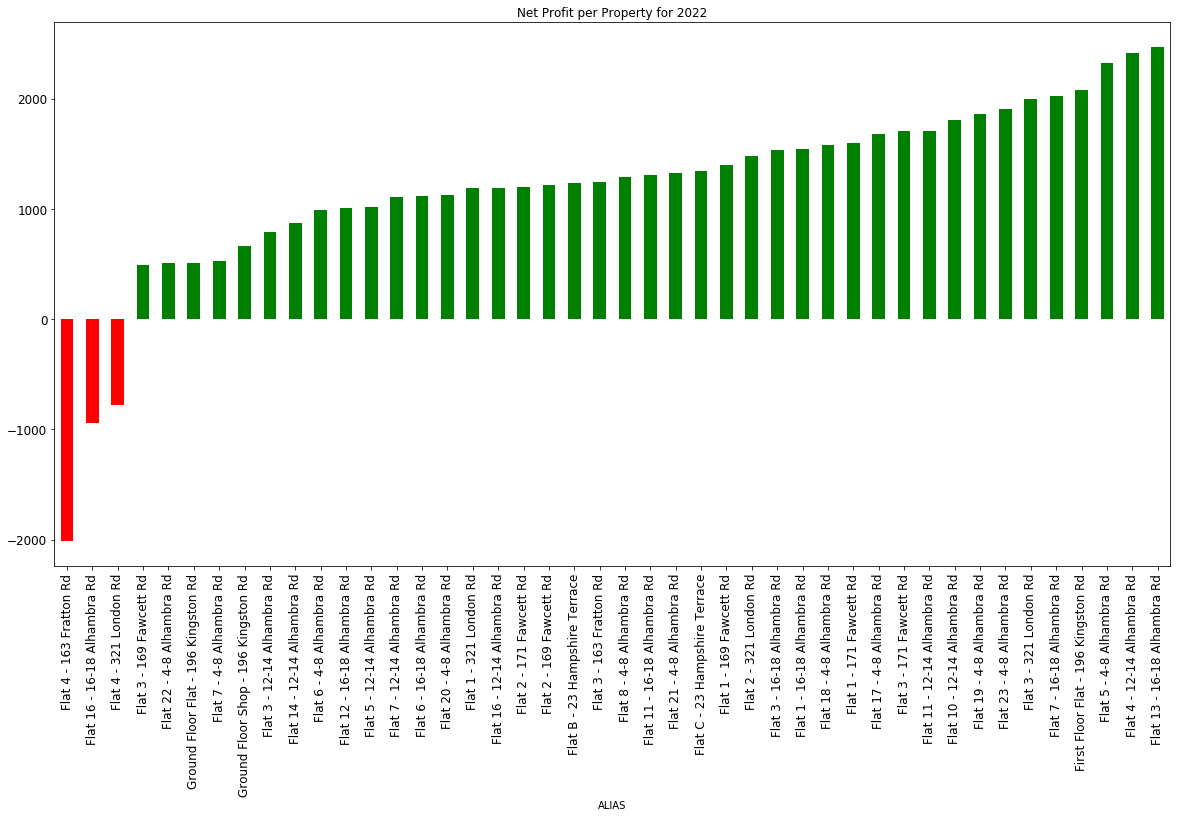

In [11]:
plot_profit_per_property_by_year(dfAll,start,end)

### Income vs Expenditure

In [12]:
dfX=get_annual_income_vs_expenditure(dfAll)
dfX

Type,Expense,Mortgage,Rent,Net
Year,,,,
2022,-21348.0,-34256.0,106940.0,51336.0


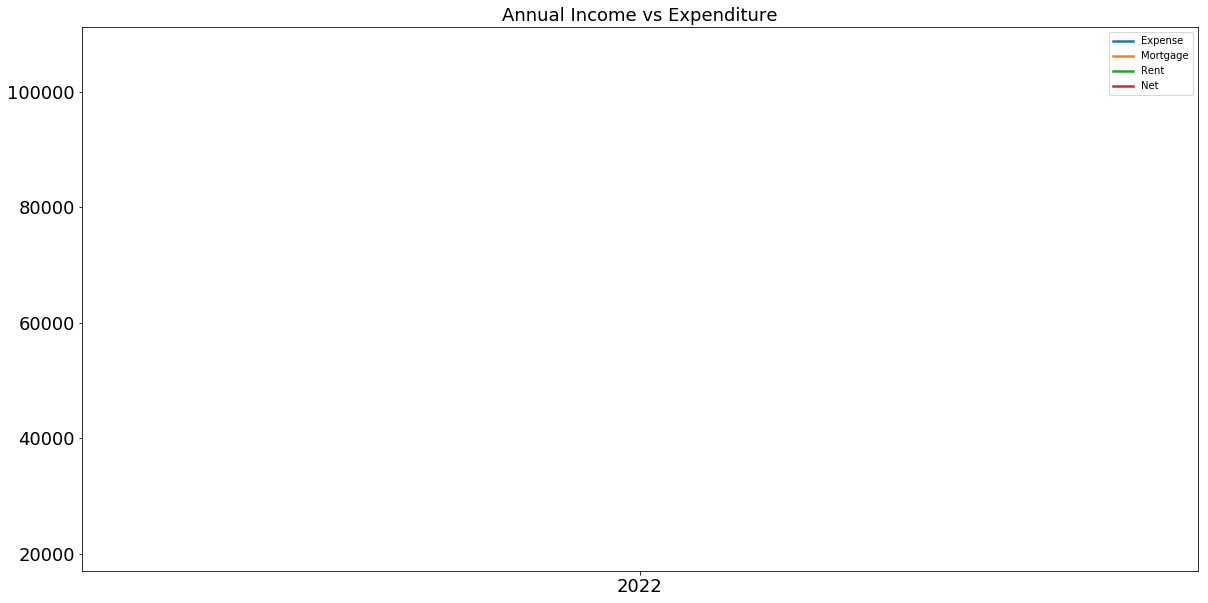

In [13]:
## Note we are making negative values absolute to make chart easier to read
plot_annual_income_vs_expenditure(dfX.abs())

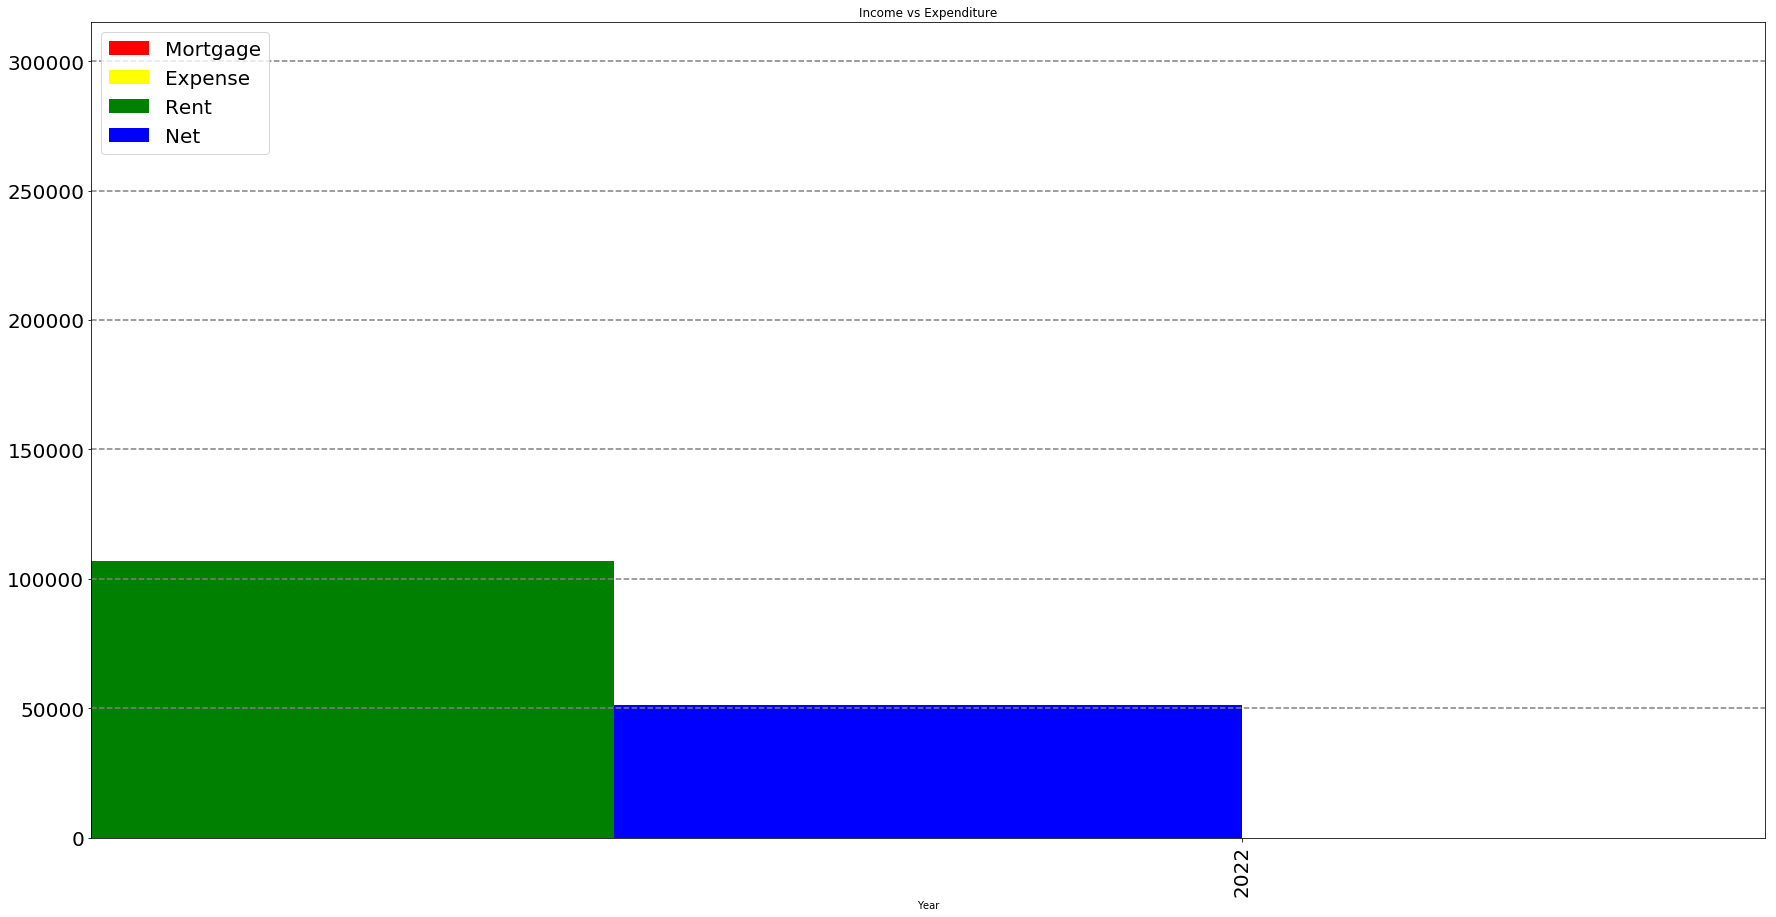

In [14]:
plot_annual_income_vs_expenditure_bar(dfX)

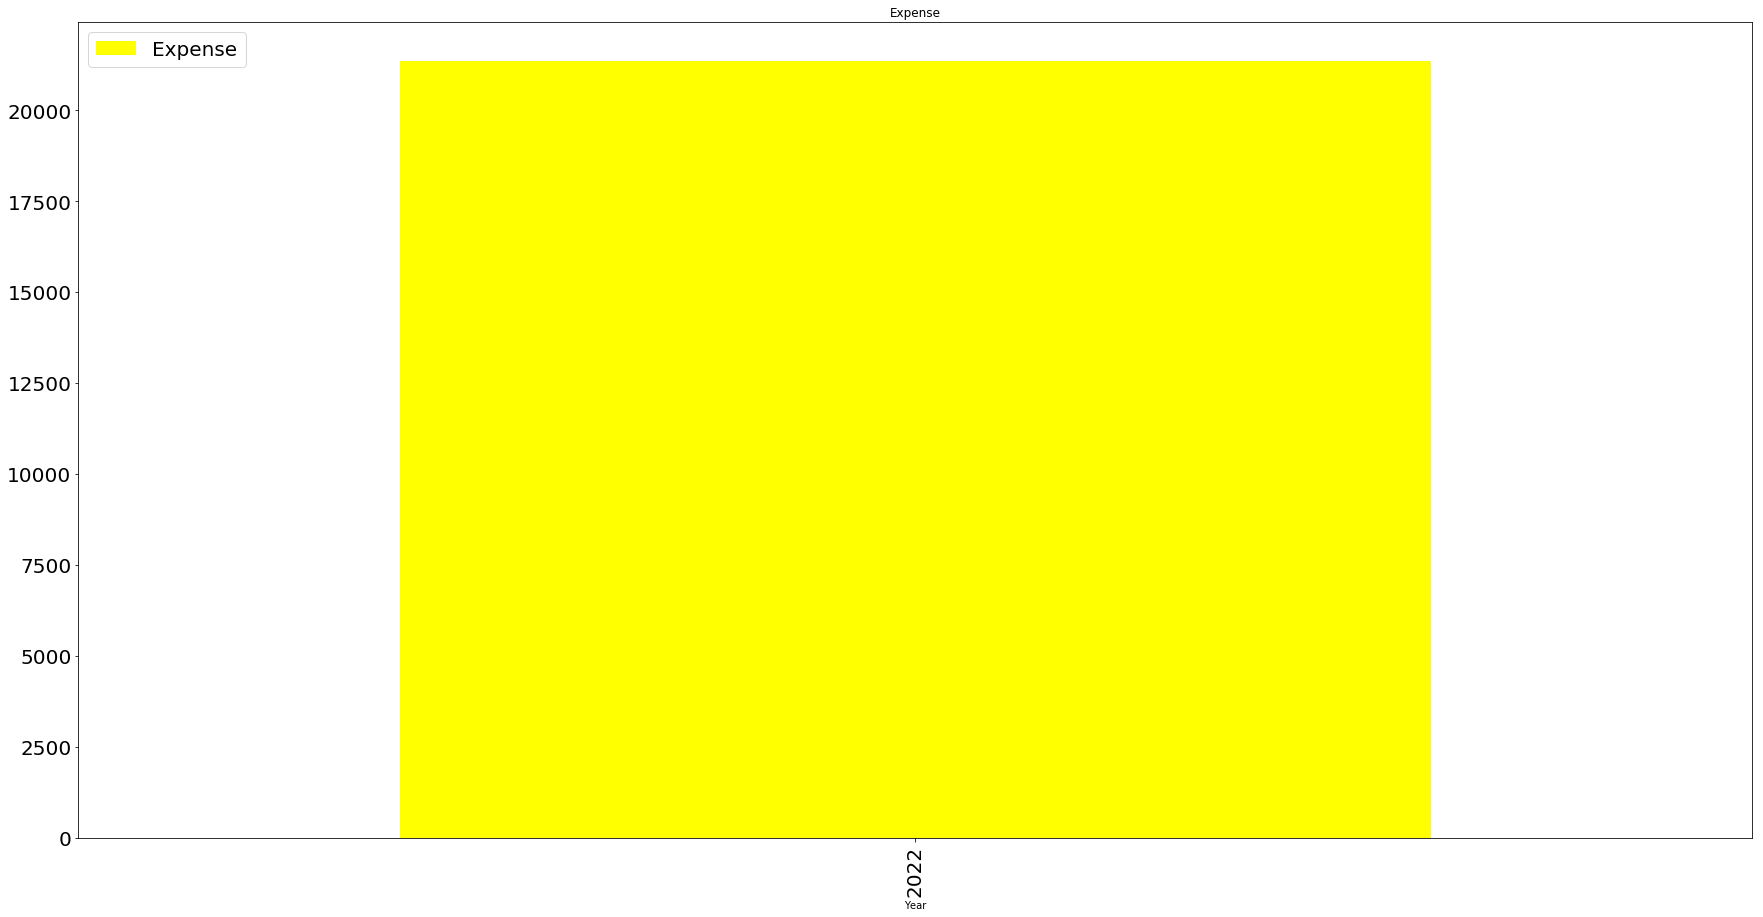

In [15]:
plot_single(dfX, 'Expense','yellow')

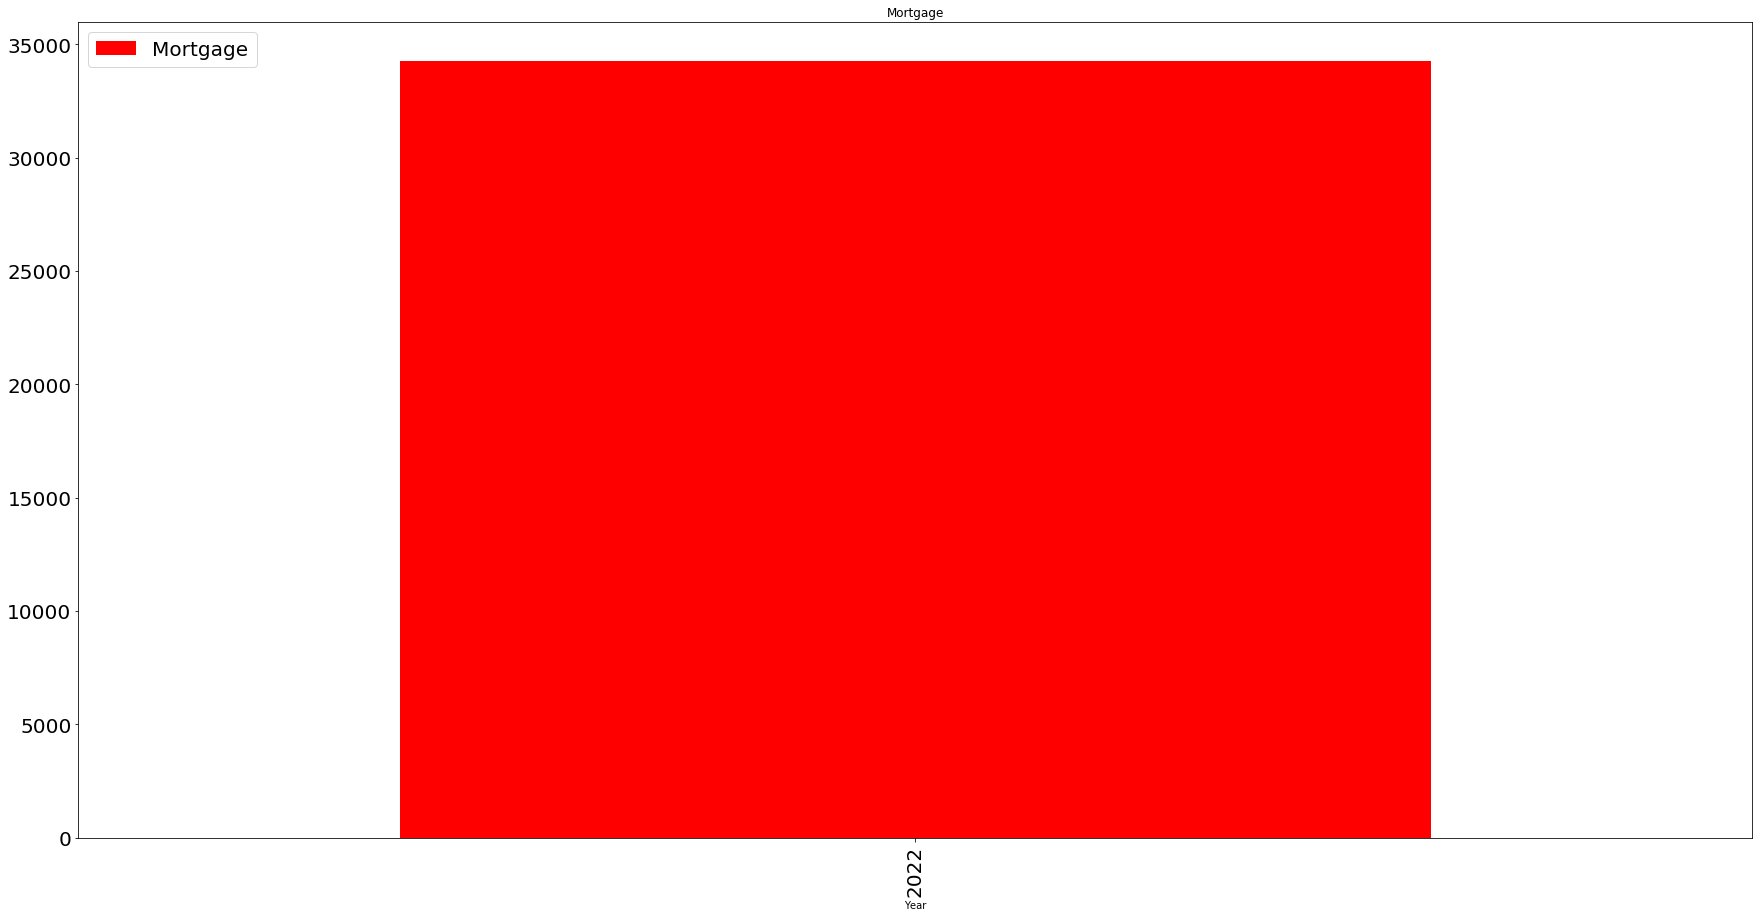

In [16]:
plot_single(dfX, 'Mortgage','red')

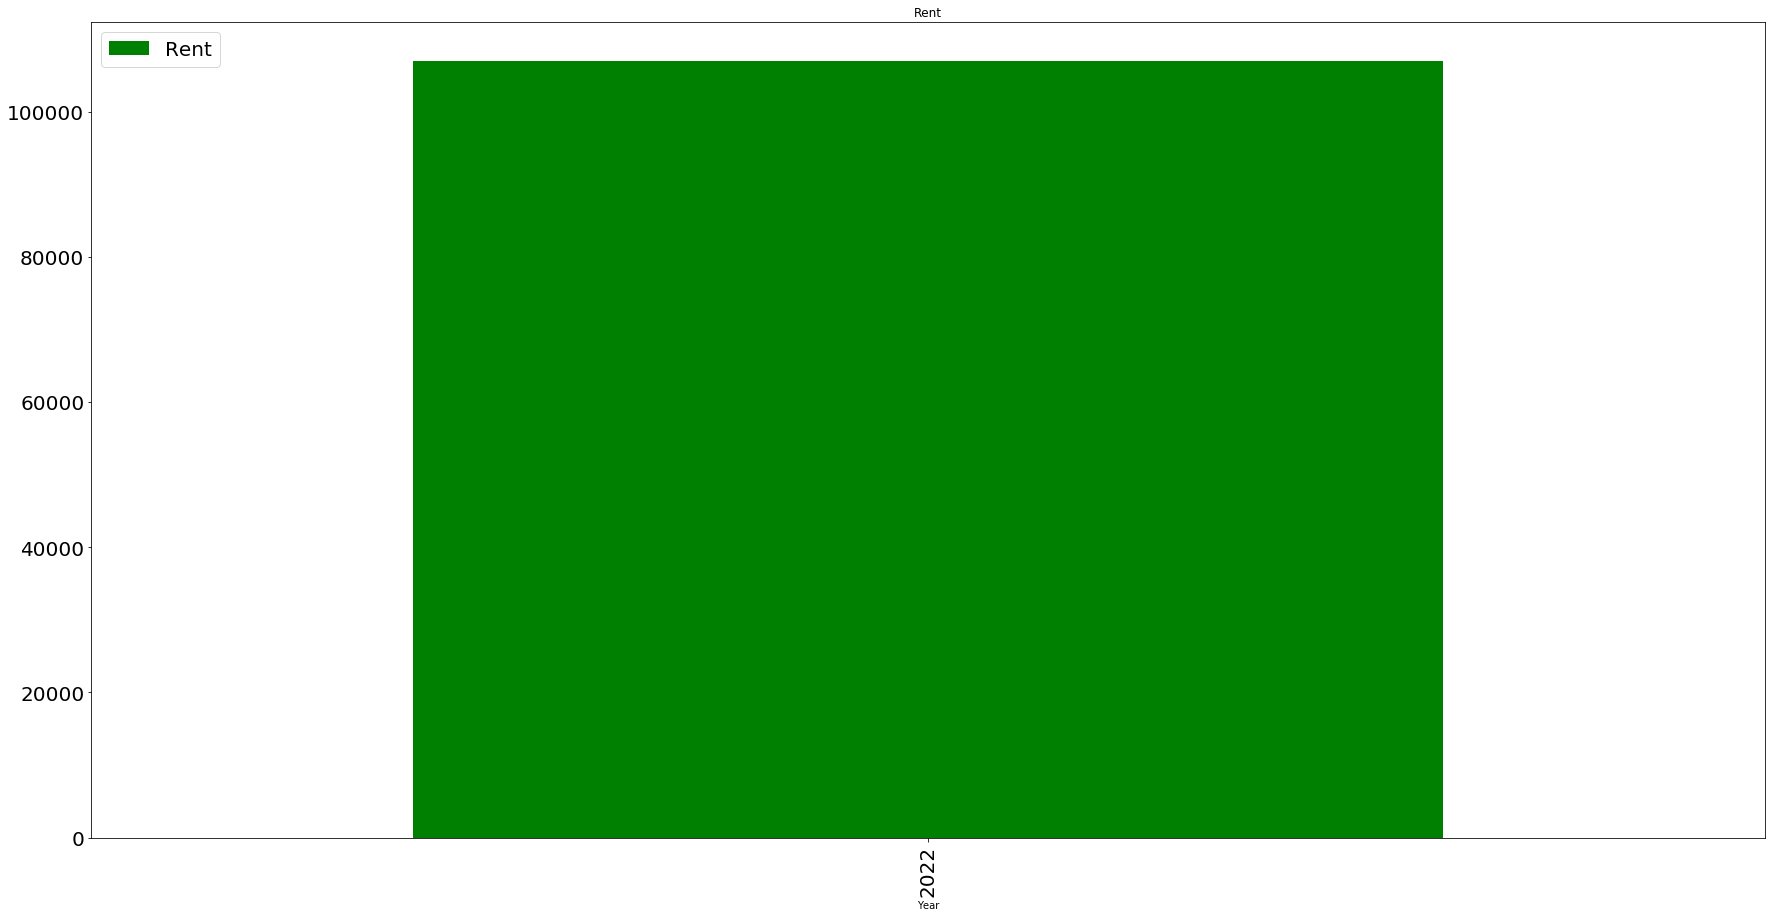

In [17]:
plot_single(dfX, 'Rent','green')

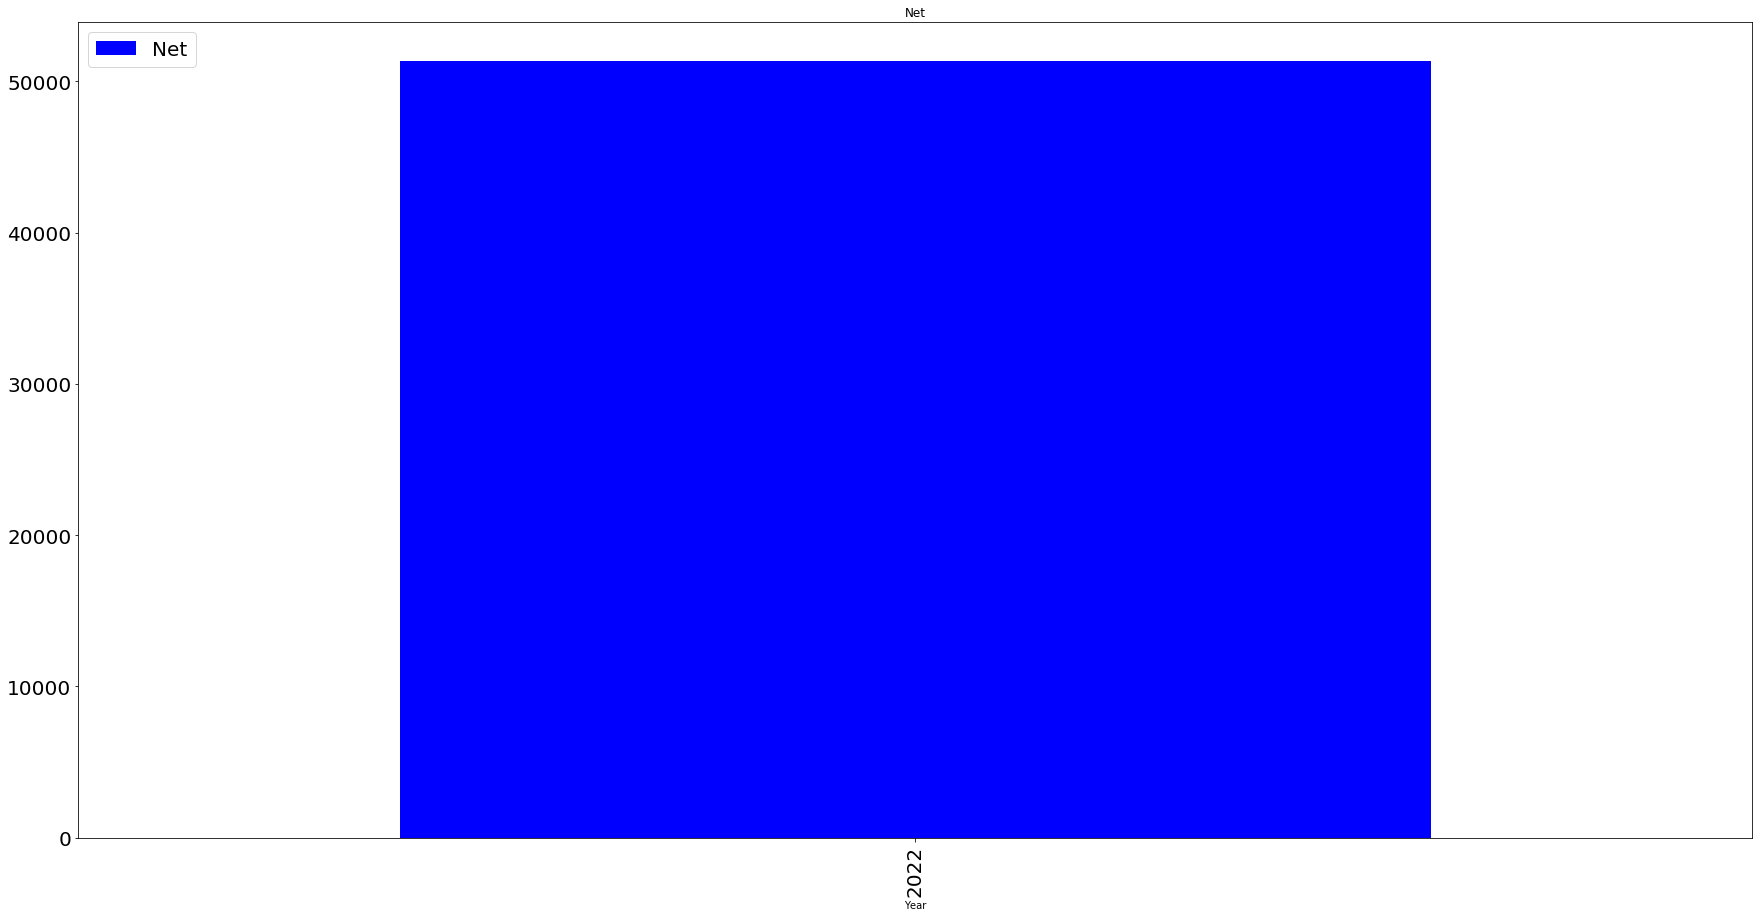

In [18]:
plot_single(dfX, 'Net','blue')